In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import datetime
import os
import IPython.display as ipd

In [13]:
# define util function

def load_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    return audio, sr

def plot_waveform(audio, sr, title):
    # plot the first audio file
    d = len(audio) / sr
    t = np.linspace(0, d, len(audio))
    plt.figure(figsize=(14, 5))
    plt.plot(t, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + title)

def get_spectrogram_tf(audio, n_fft=2048, hop_length=512):
    # get the spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.transpose(spectrogram)
    spectrogram = 10 * tf.math.log(spectrogram + 1e-9)
    return spectrogram

def get_mel_spectrogram_tf(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    # plot the mel spectrogram using tensorflow
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)    
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels, 
        num_spectrogram_bins=spectrogram.shape[-1], 
        sample_rate=sr,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sr/2.0
    )
    # mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    # mel_filter = tf.convert_to_tensor(mel_filter, dtype=tf.float32)
    # mel_filter = tf.transpose(mel_filter)
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    mel_spectrogram = tf.transpose(mel_spectrogram)
    mel_spectrogram = 10 * tf.math.log(mel_spectrogram + 1e-9)
    return mel_spectrogram

def plot_spectrogram(title, spectrogram, sr):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)

def load_16k_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    sr = tf.cast(sr, tf.int64)
    audio = tf.squeeze(audio, axis=1)
    audio = tfio.audio.resample(audio, sr, 16000)
    return audio, 16000

In [5]:
# The set of characters accepted in the transcription.
characters = [x for x in "tljˤʒkʃθʔabnu: zwʕmqɣfrsxiðħdh"]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

2024-06-04 03:41:24.782223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:41:25.265433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:41:25.265609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:41:25.273615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:41:25.273725: I external/local_xla/xla/stream_executor

The vocabulary is: ['', 't', 'l', 'j', 'ˤ', 'ʒ', 'k', 'ʃ', 'θ', 'ʔ', 'a', 'b', 'n', 'u', ':', ' ', 'z', 'w', 'ʕ', 'm', 'q', 'ɣ', 'f', 'r', 's', 'x', 'i', 'ð', 'ħ', 'd', 'h'] (size =31)


In [11]:
# define the audio file
file = 'test_data/078001_01.wav'
audio, sr = load_16k_audio_tf(file)

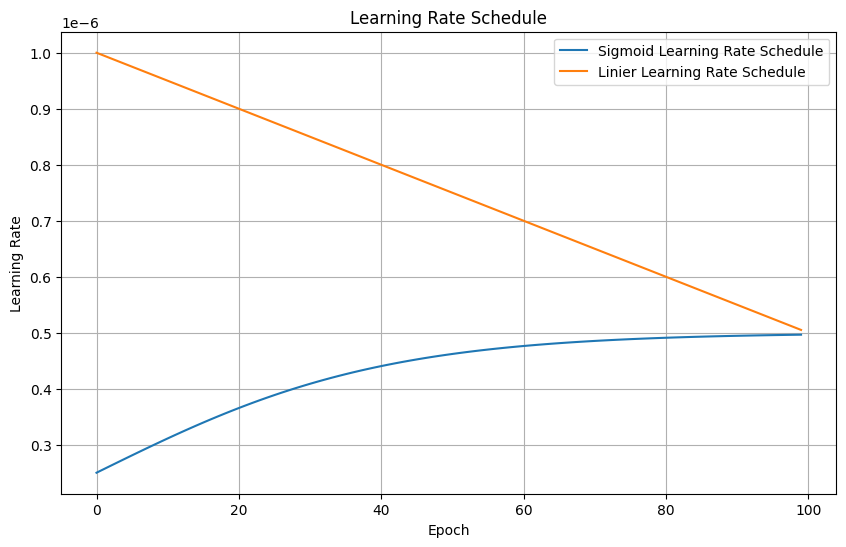

In [41]:
def sigmoid_scheduler(epoch, target_lr=0.0000005):
  epochs = 100  # Adjust for your total epochs
  return target_lr / (1 + np.exp(-5 * (epoch / epochs)))  # Adjust coefficient for steeper/shallower curve

def linier_scheduler(epoch, target_lr=0.0000005):
    epochs = 100  # Adjust for your total epochs
    initial_lr = 0.000001
    return initial_lr - (initial_lr - target_lr) * (epoch / epochs)

def custom_lr_schedule(epoch):
    if epoch < 20:
        return 1e-6 * (epoch / 20)  # Linear warm-up to 1e-6
    elif epoch < 40:
        return 1e-6
    else:
        return 1e-6 * tf.math.exp(0.1 * (20 - epoch / 20))  # Exponential decay

sigmoid_lrs = []
linier_lrs = []
custom_lrs = []

for i in range(100):
    learning_rate = sigmoid_scheduler(i)
    sigmoid_lrs.append(learning_rate)
    learning_rate = linier_scheduler(i)
    linier_lrs.append(learning_rate)    
    learning_rate = custom_lr_schedule(i)
    custom_lrs.append(learning_rate)

plt.figure(figsize=(10, 6))
plt.plot(sigmoid_lrs, label='Sigmoid Learning Rate Schedule')
plt.plot(linier_lrs, label='Linier Learning Rate Schedule')
# plt.plot(custom_lrs, label="Custom Learning Rate Schedule")
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
ipd.Audio(audio.numpy(), rate=sr)

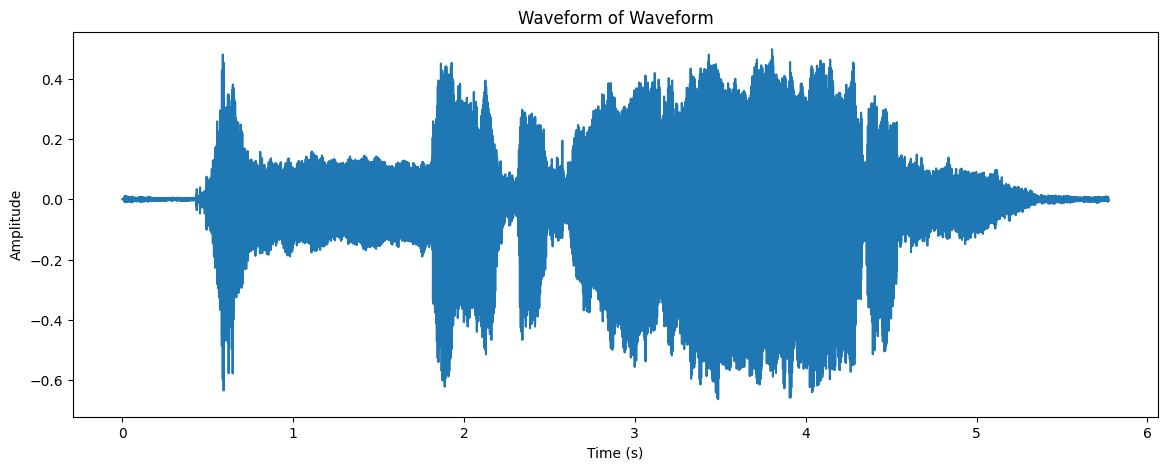

In [15]:
# play audio and show waveform
plot_waveform(audio.numpy(), sr,  "Waveform")

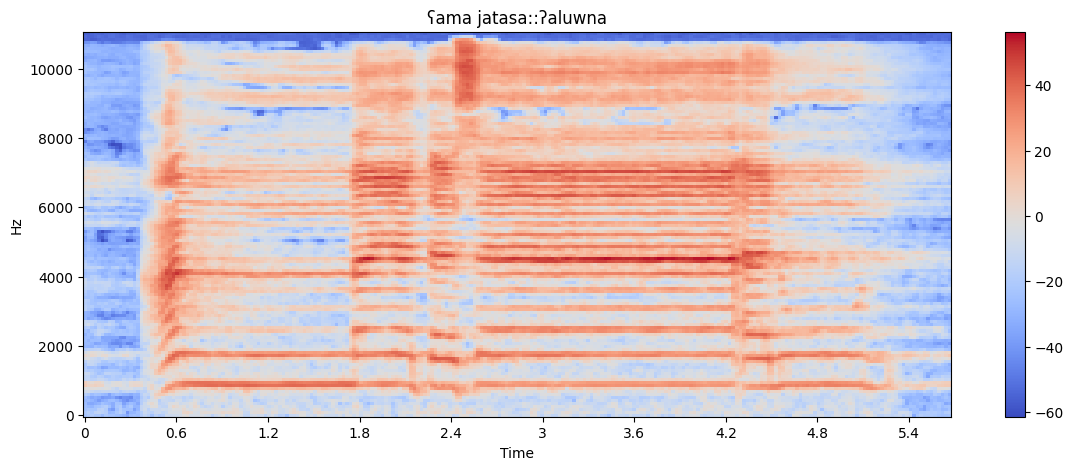

In [93]:
# get mel spectrogram
mel_spectrogram = get_mel_spectrogram_tf(audio.numpy(), sr.numpy())

# get the labels
transcription = "ʕama jatasa::ʔaluwna"
# Convert label to Lower case
label = tf.strings.lower(transcription)
# Split the label
label = tf.strings.unicode_split(label, input_encoding="UTF-8")
# Map the characters in label to numbers
label = char_to_num(label)

plot_spectrogram(transcription, mel_spectrogram.numpy(), sr.numpy())

In [72]:
mel_spectrogram.shape

TensorShape([128, 245])

In [94]:
# get the input dimension from the mel bins
x = mel_spectrogram

x = tf.expand_dims(x, axis=-1)
x = tf.expand_dims(x, axis=0)
print("mel_spectrogram shape:", x.shape)

mel_spectrogram shape: (1, 128, 245, 1)


In [95]:
x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_1"
    )(x)
x = layers.LayerNormalization(name="ln_1")(x)
print(x)

tf.Tensor(
[[[[ 0.4066271  -1.3846341  -0.01027394 ... -0.781983   -0.9819549
    -1.5400777 ]
   [ 0.714301   -1.2518831   0.64782536 ... -0.8387243  -0.77160484
    -0.3612323 ]
   [ 0.6473894  -1.2884266   0.58094656 ... -0.89945704 -0.7785597
    -0.5692157 ]
   ...
   [ 0.64936775 -1.2245479   0.61757207 ... -0.8376479  -0.78560024
    -0.5825208 ]
   [ 0.66061383 -1.1827383   0.75251764 ... -0.82773006 -0.75747216
    -0.4598986 ]
   [ 0.5199041  -0.41071233  1.033419   ... -0.29539305 -0.2771103
    -0.24983504]]

  [[-0.3443558  -0.7997406  -0.043715   ... -0.72606575 -0.6455253
    -0.9184247 ]
   [-0.33068725 -0.8529423   0.71346474 ... -0.32543227 -1.0072842
    -0.0218441 ]
   [-0.3657019  -0.78138417  0.73772496 ... -0.18742087 -0.9104629
    -0.12367716]
   ...
   [-0.3617351  -0.79774266  0.6286735  ... -0.29282305 -0.935292
    -0.11131708]
   [-0.3785539  -0.7186944   0.6957547  ... -0.24569812 -0.9540748
     0.04201153]
   [-0.61069125  0.4710408   0.33436528 ...  0.

In [96]:
x = layers.Activation("gelu", name="gelu_1")(x)
print(x)

tf.Tensor(
[[[[ 0.26750332 -0.11503845 -0.00509486 ... -0.16977814 -0.1601186
    -0.09513164]
   [ 0.5446399  -0.13183111  0.48033077 ... -0.16842595 -0.1698875
    -0.129669  ]
   [ 0.47991624 -0.12729499  0.41791075 ... -0.16568418 -0.1698191
    -0.16200155]
   ...
   [ 0.4817982  -0.13515683  0.45179796 ... -0.1684629  -0.1697296
    -0.16316871]
   [ 0.49253386 -0.14010298  0.58254653 ... -0.16878384 -0.16996428
    -0.14845273]
   [ 0.36311913 -0.13990577  0.87767875 ... -0.11338568 -0.10830793
    -0.10027315]]

  [[-0.12578952 -0.16948944 -0.02109537 ... -0.16982621 -0.16738047
    -0.16458015]
   [-0.12249991 -0.167898    0.5438177  ... -0.12119976 -0.158042
    -0.0107317 ]
   [-0.130663   -0.1697856   0.5677968  ... -0.07977857 -0.16505712
    -0.05575186]
   ...
   [-0.12978151 -0.16952826  0.46221244 ... -0.11268672 -0.16350675
    -0.05072524]
   [-0.13344386 -0.16973017  0.5264837  ... -0.09900602 -0.16221456
     0.02170967]
   [-0.16531534  0.32087025  0.21096712 ... 